## Импорты

In [2]:
# импортируем необходимые библиотеки, классы и функции
import os
import winsound
from etna.core import load
from etna.analysis import plot_backtest, plot_forecast
import random
from functools import partial
from pathlib import Path
import numpy as np
import optuna
import pandas as pd
from etna.datasets import TSDataset
from etna.datasets import generate_ar_df
from etna.metrics import (MAE, MSE, SMAPE, Sign)
from etna.models import ElasticPerSegmentModel
from etna.pipeline import Pipeline, AutoRegressivePipeline
from etna.transforms import (LagTransform, 
                             LogTransform, 
                             LinearTrendTransform,
                             TrendTransform)
from etna.transforms import (SegmentEncoderTransform,
                             StandardScalerTransform, 
                             MinMaxScalerTransform, 
                             TimeSeriesImputerTransform)
from etna.transforms.decomposition import RupturesChangePointsModel
from ruptures.detection import Binseg
from etna.datasets import generate_ar_df
import warnings
warnings.filterwarnings('ignore')

## Функция загрузки данных и преобразования в формат ETNA

In [3]:
def get_etna_dataframe(sw_path, using_measure_points, target_list, regressors_list):
  # Получаем очищенные данные
  df = pd.read_csv(sw_path)
  df = df.head(using_measure_points)
  # преобразовываем столбец timestamp в столбец с временными метками
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df_target = df[target_list]
  df_regressors = df[regressors_list]
  # Подготавливаем регрессоры
  if regressors_list:
    df_regressors.columns = ["timestamp"] + [f"regressor_{i}" for i in range(len(regressors_list)-1)]
    df_regressors["segment"] = "segment_0"
    df_regressors = TSDataset.to_dataset(df_regressors)
  # подготавливаем dataframe с целевой переменной
  df_target['target'] = df_target['v_plasma']
  df_target.drop(columns=['v_plasma'], inplace=True)
  df_target['segment'] = 'segment_0'
  # превращаем датафрейм
  # с плоским индексом в датафрейм с мультииндексом
  df_target = TSDataset.to_dataset(df_target)
  # превращаем датафрейм в объект TSDataset
  if not regressors_list:
    ts_target = TSDataset(df_target, freq='h')
  else:
    ts_target = TSDataset(df_target, freq='h', df_exog=df_regressors)
  # выполняем импутацию пропусков
  imputer = TimeSeriesImputerTransform(in_column='target',
                                      strategy='running_mean')
  ts_target.fit_transform([imputer])

  if regressors_list:
    for i in range(len(regressors_list)-1):
      imputer = TimeSeriesImputerTransform(in_column=f"regressor_{i}",
                                      strategy='running_mean')
      ts_target.fit_transform([imputer])

  return ts_target

## Функция отображения статистик по TSData и Pipeline

In [4]:
def print_TSDataset_statistic(df: TSDataset):
    print(f"*** Статистика по набору данных: ***\n {df.describe()} ]\n\n")
    print("Минимальные значения:")
    print(df.df.min())
    print("\nМаксимальные значения:")
    print(df.df.max())

def print_pipeline_transform_and_regressors(pipeline, regressors):
    print("\nСписок преобразований пайплайна:\n")
    for transform in pipeline.transforms:
        print(transform)
    print(f"\n*** Переменные регрессоры: ***\n {regressors_list} \n \n")

def play_end_sound():
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)
    winsound.PlaySound('SystemAsterisk', winsound.SND_FILENAME)

## Функция создания модели, трансформеров, пайплайна и обучения модели

In [9]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)


def learn_model(horizon, 
                lags,
                model_param_l1ratio,
                model_param_aplpha,
                target_list: list = None, 
                regressors_list: list = None, 
                ts: TSDataset = None,
                with_saving_model: bool = False,
               ):
    set_seed()
    transforms=[
            # StandardScalerTransform(in_column=None),
             MinMaxScalerTransform(in_column=None),
             LagTransform(in_column="target", 
                          lags=list(range(1, lags)),
                          out_column="lag_target")
              ]

    # создаем экземпляр класса LogTransform для логарифмирования
    # и экспоненцирования зависимой переменной
    # mult_log = LogTransform(in_column='target')
    # # создаем экземпляр класса LinearTrendTransform
    # # для прогнозирования линейного тренда, его
    # # удаления из данных и добавления к прогнозам
    # mult_linear_trend = LinearTrendTransform(in_column='target')
    # # # создаем экземпляр класса TrendTransform
    # # # для создания тренда в качестве признака
    # # mult_trend_feat = TrendTransform(in_column='target', 
    # #                                  change_points_model=RupturesChangePointsModel(change_points_model=Binseg(model='ar'), 
    # #                                                                                n_bkps=horizon), 
    # #                                  out_column='trend_feat')
    # transforms.append(mult_log)
    # transforms.append(mult_linear_trend)
    # transforms.append(mult_trend_feat)
    
    # если список регрессоров не пуст, то добавляем лаги для них
    if regressors_list:
      for i in range(len(regressors_list)-1):
        lags_regressor = LagTransform(in_column=f"regressor_{i}",
                                      lags=list(range(horizon, horizon+lags)),
                                      out_column=f"lag_regressor_{i}")
        transforms.append(lags_regressor)

    # задаем модель и признаки
    pipeline = AutoRegressivePipeline(
        # эластичная сеть (0 <l1_ratio <1), 
        # лассо (l1_ratio = 1)
        # гребневую регрессию (l1_ratio = 0)
        # alpha - параметр, определяющий силу регуляризации
        model = ElasticPerSegmentModel(alpha=model_param_aplpha,
                                       l1_ratio=model_param_l1ratio,
                                       fit_intercept=False),
        transforms=transforms,
        horizon=horizon,
        step=1,
    )
    print("\n*** Запустился pipeline ***\n")
    metrics, forecast_df, fold_info_df = pipeline.backtest(ts=ts, 
                                      metrics=[MAE(), SMAPE(), MSE()],
                                      n_jobs=6,
                                      n_folds=5,
                                      aggregate_metrics=False
                                      )
    print_pipeline_transform_and_regressors(pipeline, regressors_list)
    print(f"Параметры модели ElasticPerSegmentModel: {pipeline.model.to_dict}")
    if with_saving_model:
        pipeline.fit(ts)
        pipeline.save('C:\\Users\\andre\\OneDrive\\Рабочий стол\\ВКР\\Модели\\linear_regression_etna.zip')
    return metrics, forecast_df, fold_info_df

## Запуск обучения

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2018-12-31 23:00:00  166560            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1          1               0                 0    h   ]


Минимальные значения:
segment    feature    
segment_0  regressor_0   -422.0
           target         233.0
dtype: float64

Максимальные значения:
segment    feature    
segment_0  regressor_0      77.0
           target         1189.0
dtype: float64

*** Запустился pipeline ***



[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed: 28.4min
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed: 36.8min remaining: 55.2min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed: 42.3min remaining: 28.2min
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed: 42.6min finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   49.0s
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:   49.4s remaining:  1.2min
[Parallel(n_jobs=6)]: Done   3 out of   5 | elapsed:   49.5s remaining:   33.0s
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:   50.1s finished
[Parallel(n_jobs=6)]: Using backend MultiprocessingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=6)


Список преобразований пайплайна:

MinMaxScalerTransform(in_column = None, inplace = True, out_column = None, feature_range = (0, 1), clip = True, mode = 'per-segment', )
LagTransform(in_column = 'target', lags = [1, 2, 3, 4, 5, 6, 7, 8, 9], out_column = 'lag_target', )
LagTransform(in_column = 'regressor_0', lags = [72, 73, 74, 75, 76, 77, 78, 79, 80, 81], out_column = 'lag_regressor_0', )

*** Переменные регрессоры: ***
 ['timestamp', 'Dst'] 
 

Параметры модели ElasticPerSegmentModel: <bound method BaseMixin.to_dict of ElasticPerSegmentModel(alpha = 0, l1_ratio = 0.5, fit_intercept = False, )>

*** Метрики обучения по сегментам ***
     segment        MAE      SMAPE          MSE  fold_number
0  segment_0  57.430088  13.940277  4601.265590            0
0  segment_0  67.806177  14.562596  6121.912871            1
0  segment_0  52.599371  14.469374  3117.891074            2
0  segment_0  70.983062  16.594473  8180.779576            3
0  segment_0  25.733482   4.940479   891.516415     

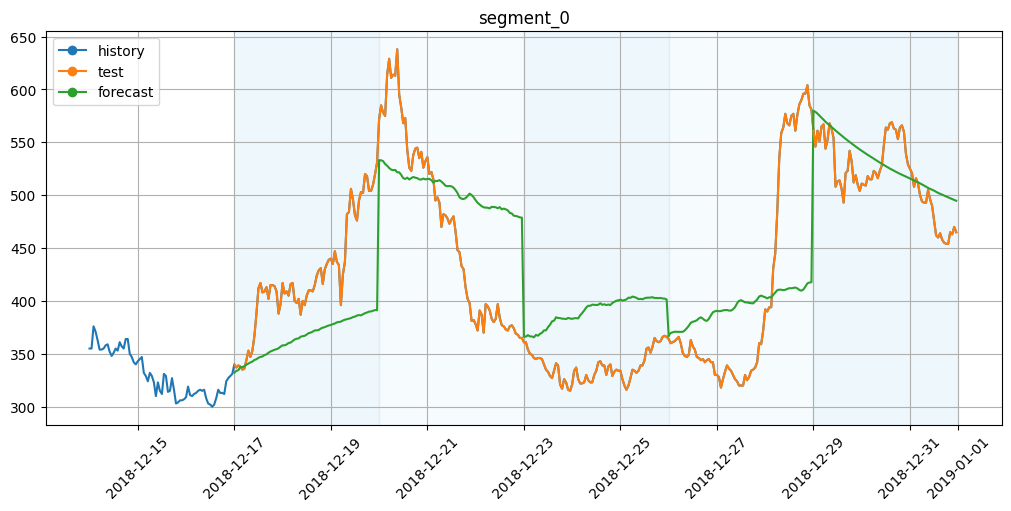

In [11]:
target_list = ['timestamp',
              'v_plasma']

regressors_list = [
                   'timestamp',
                   #'AL', # какие-то проблемы
                   # 'AU', # нет пропусков
                   # 'AE', # нет пропусков
                   # 'Kp', # нет пропусков
                   # 'p_flow', # нет пропусков
                   # 'n_p', # нет пропусков
                   # 'n_plasma', # нет пропусков
                   # 'R', # нет пропусков
                   # 'f107_adj', # нет пропусков
                   'Dst' # нет пропусков
]
using_measure_points = 166560
horizon = 72

ts = get_etna_dataframe('C:\\Users\\andre\\OneDrive\\Рабочий стол\\df_clean.csv',
                        using_measure_points,
                        target_list, 
                        regressors_list)
print_TSDataset_statistic(ts)

metrics, forecast_df, fold_info = learn_model(horizon = 72,
                                              ts = ts,
                                              lags = 10,
                                              model_param_l1ratio=0.5,
                                              model_param_aplpha=0,
                                              regressors_list = regressors_list,
                                              with_saving_model=False)
plot_backtest(forecast_df, ts, history_len=72)
print("\n*** Метрики обучения по сегментам ***")
print(metrics)
play_end_sound()


## Получение предсказания

*** Статистика по датасету для прогнозирования ***

*** Статистика по набору данных: ***
           start_timestamp       end_timestamp  length  num_missing  \
segments                                                             
segment_0      2000-01-01 2019-07-18 15:00:00  171328            0   

           num_segments  num_exogs  num_regressors  num_known_future freq  
segments                                                                   
segment_0             1          1               0                 0    h   ]


Минимальные значения:
segment    feature    
segment_0  regressor_0      0.0
           target         233.0
dtype: float64

Максимальные значения:
segment    feature    
segment_0  regressor_0       9.0
           target         1189.0
dtype: float64
*** Статистика по датасету c настоящими значениями прогноза ***

*** Статистика по набору данных: ***
               start_timestamp       end_timestamp  length  num_missing  \
segments                              

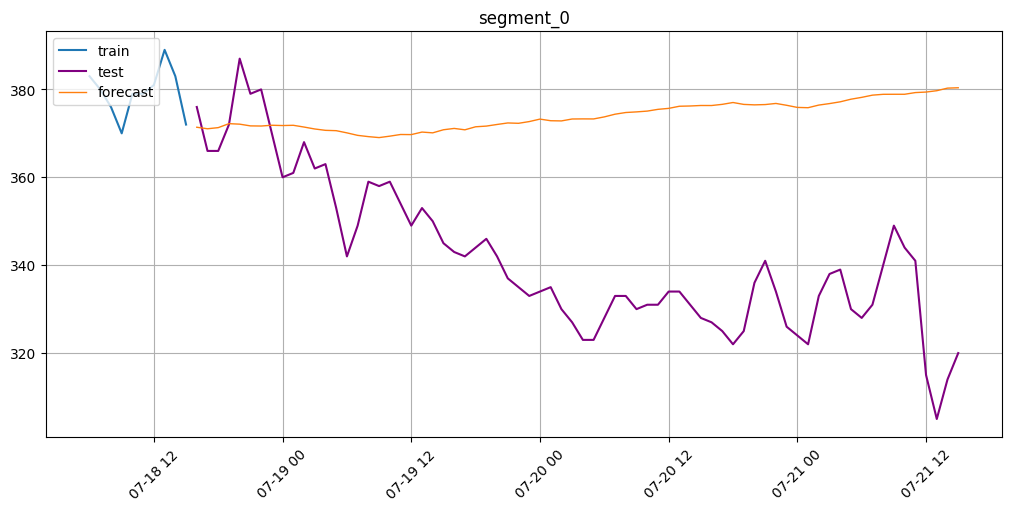

In [650]:
# Количество временных шагов для предсказания
HORIZON = 72
MEASURE_POINT_END =  171400 # 175320
PATH_TO_DATASET = "C:\\Users\\andre\\OneDrive\\Рабочий стол\\df_clean.csv"

df_for_predict = get_etna_dataframe(sw_path=PATH_TO_DATASET,
                                    using_measure_points=(MEASURE_POINT_END - HORIZON),
                                    target_list=target_list, 
                                    regressors_list=regressors_list)

df_real = get_etna_dataframe(sw_path=PATH_TO_DATASET,
                             using_measure_points=MEASURE_POINT_END,
                             target_list=target_list, 
                             regressors_list=regressors_list)
df_real = TSDataset(df_real.df.tail(horizon), freq='h')

print("*** Статистика по датасету для прогнозирования ***\n")
print_TSDataset_statistic(df_for_predict)
print("*** Статистика по датасету c настоящими значениями прогноза ***\n")
print_TSDataset_statistic(df_real)

pipeline = load("C:\\Users\\andre\\OneDrive\\Рабочий стол\\ВКР\\Модели\\linear_regression_etna.zip")
print_pipeline_transform_and_regressors(pipeline, regressors_list)

print("Получаем предсказание...")

forecast = pipeline.forecast(df_for_predict)

plot_forecast(forecast_ts=forecast, test_ts=df_real, train_ts=df_for_predict, n_train_samples=10)

print(f"""Последние три значения датафрейма для предсказания:\n{df_for_predict.tail(3)}\n\n 
Предсказание(первые 3):\n {forecast.df["segment_0"]["target"].head(3)}\n\n 
Реальные данные (первые 3):\n {df_real.df["segment_0"]["target"].head(3)}\n\n
""")
play_end_sound()